## ReAct Agent

![alt text](reAct.jpg)

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(
    top_k_results=2,
    doc_content_chars_max=500
)

arxiv  = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
api_wrapper_wiki = WikipediaAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=250
)

wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACKING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-Agent"

In [6]:
## Custom functions (tools)

def add(a : int, b : int) -> int:
    """Add a and b

    Args:
        a (int): first int
        b (int): second int
    """
    return a + b

def multiply(a : int, b : int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int
    """
    return a * b

def divide(a : int, b : int) -> float:
    """Divide a and b

    Args:
        a (int): first int
        b (int): second int
    """
    return a / b

In [7]:
## Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\BOSS\AppData\Local\Temp\ipykernel_36764\1622265974.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
## All tools
tools = [arxiv, wiki, tavily, add, multiply, divide]

In [9]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage

In [10]:
llm = ChatGroq(
    model="qwen/qwen3-32b"
)

llm_with_tools = llm.bind_tools(tools)

In [11]:
llm_with_tools.invoke([HumanMessage(content="What is 2 plus 2?")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is 2 plus 2?" Let me see which tool I can use here. The available functions include add, multiply, divide, and some others for searching. Since the question is about addition, the \'add\' function is the right choice. The parameters required are a and b, both integers. Here, a is 2 and b is 2. So I should call the add function with these values. I don\'t need to use any other tools here because it\'s a straightforward arithmetic problem. Let me make sure there\'s no trick or hidden part in the question. Nope, it\'s just asking for 2 plus 2. So the answer should be 4.\n', 'tool_calls': [{'id': 'k1h7razzq', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 175, 'prompt_tokens': 478, 'total_tokens': 653, 'completion_time': 0.288115057, 'prompt_time': 0.618842204, 'queue_time': 1.6732765729999999, 'total_time':

In [12]:
llm_with_tools.invoke([HumanMessage(content="What is 2 plus 2?")]).tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'ym3qbfn3q',
  'type': 'tool_call'}]

In [13]:
### Chatbot with LangGraph
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from typing_extensions import TypedDict
from typing import Annotated

In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
# Node function
def tool_calling(state : State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [16]:
## Build graph

builder = StateGraph(State)

builder.add_node('tool_calling', tool_calling)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling")
builder.add_conditional_edges(
    "tool_calling",
    tools_condition
)
builder.add_edge("tools", "tool_calling")

graph = builder.compile()

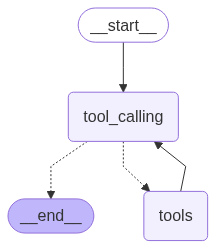

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = graph.invoke({"messages" : HumanMessage(content="Provide me the top 10 recent AI news for August 2025,add 5 plus 5 and then multiply by 2 ")})

for message in messages["messages"]:
    message.pretty_print()
    

================================ Human Message =================================

Provide me the top 10 recent AI news for August 2025,add 5 plus 5 and then multiply by 2 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8exbm7826)
 Call ID: 8exbm7826
  Args:
    query: top 10 recent AI news August 2025
  add (v0cq5yrbq)
 Call ID: v0cq5yrbq
  Args:
    a: 5
    b: 5
  multiply (n7qcze6jt)
 Call ID: n7qcze6jt
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Briefs BULLETIN BOARD for August 2025", "url": "https://radicaldatascience.wordpress.com/2025/08/04/ai-news-briefs-bulletin-board-for-august-2025/", "content": "[8/4/2025] Kaggle Introduces Game Arena: New Competitive Benchmark for AI – Today, Kaggle\\, in partnership with Google DeepMind, launched the Kaggle Game Arena, a new public benchmarking pla

In [19]:
messages = graph.invoke({"messages" : HumanMessage(content="What is machine learning?")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (f9zawvvwx)
 Call ID: f9zawvvwx
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks wit
================================== Ai Message ==================================

Machine learning (ML) is a field of study within artificial intelligence (AI) focused on developing statistical algorithms that enable systems to **learn from data**, identify patterns, and **generalize to unseen data**. These algorithms improve their performance on tasks over time witho

## Agent Memory

In [22]:
messages = graph.invoke({"messages" : HumanMessage(content="My name is Mahadi Hasan")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

My name is Mahadi Hasan
================================== Ai Message ==================================

Hello Mahadi Hasan! Nice to meet you. How can I assist you today?


In [23]:
messages = graph.invoke({"messages" : HumanMessage(content="Who am I?")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Who am I?
================================== Ai Message ==================================

The question "Who am I?" is quite ambiguous. Could you clarify what you're asking about? Are you trying to understand your own identity, or are you asking about the AI assistant's identity?提供更多细节 will help me assist you better.


#### LangGraph can use a checkpointer to automatically save the graph state after each step

In [ ]:
## Build graph

builder = StateGraph(State)

builder.add_node('tool_calling', tool_calling)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling")
builder.add_conditional_edges(
    "tool_calling",
    tools_condition
)
builder.add_edge("tools", "tool_calling")


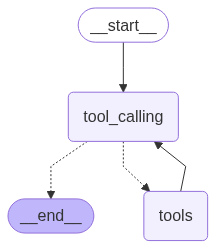

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [34]:
## specify the thread (collection of checkpointer)

config = {
    "configurable" : {"thread_id" : "1"}
}

messages = graph_memory.invoke({"messages" : HumanMessage(content="My name is Mahadi Hasan")}, config=config)

for message in messages["messages"]:
    message.pretty_print()


================================ Human Message =================================

My name is Mahadi Hasan
================================== Ai Message ==================================

Hello, Mahadi Hasan! How can I assist you today?


In [35]:
messages = graph_memory.invoke({"messages" : HumanMessage(content="Who am I?")}, config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

My name is Mahadi Hasan
================================== Ai Message ==================================

Hello, Mahadi Hasan! How can I assist you today?
================================ Human Message =================================

Who am I?
================================== Ai Message ==================================

You are Mahadi Hasan, as you introduced yourself earlier. Is there something specific you'd like to discuss or ask about?
